# 5LSL0 Assignment 4: Deep Unfolding
---

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# local imports
import MNIST_dataloader
import Fast_MRI_dataloader

# Set torches random seed
torch.random.manual_seed(0)

# Define parameters
data_loc1 = 'D://5LSL0-Datasets'
data_loc2 = './Fast_MRI_Knee'

## Week 1

### Loading MNIST dataset

In [ ]:
# Define batch size
batch_size = 64

# Create dataloaders
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc1, batch_size)

# Print the number of batches for training and testing
print(f"Number of training batches: {len(train_loader)}"
        f"\nNumber of test batches: {len(test_loader)}")

# Get some examples as the first 10 correspond to the digits 0-9
_, (x_clean_example, x_noisy_example, labels_example) = next(enumerate(test_loader))

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# Access the entire training and test set for later use
clean_train = train_loader.dataset.Clean_Images # 60000 training images
noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

clean_test  = test_loader.dataset.Clean_Images # 10000 test images
noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# Access 10 examples as representations for all digits
clean_example = clean_test[0:10,:,:,:]
noisy_example = noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

## Exercise 1 - ISTA

### (a) [3 pt] Create a Python function that implements ISTA for MNIST denoising. 

- Make sure the function takes as inputs: step size `μ`, shrinkage parameter `λ`, number of iteration `K`, and measurements (batch of MNIST images) `y`. 
- It should output the final batch of reconstructions x<sub>K</sub>.
- HINT: The images are normalized between -1 and 1, which means the background of the images is not at zero. Think about how to still aply ISTA correctly.

In [ ]:
# Soft thresholding function
def softthreshold(x, shrinkage):
    return torch.sign(x) * torch.max(torch.abs(x) - shrinkage, torch.tensor(0.0))

# ISTA function
def ISTA(mu, shrinkage, K, y):
    # Initialize x to be the same as y
    x = y.clone() 
    
    # Iteratively apply the soft thresholding function
    for _ in tqdm(range(K)):
        # Compute the gradient
        x = x - mu * (x - y)
        # Shrinkage step
        x = softthreshold(x, mu * shrinkage)
    
    # Normalize the final batch of reconstructions to be between -1 and 1
    x = 2 * (x - x.min()) / (x.max() - x.min()) - 1
    
    # Return the final batch of reconstructions
    return x

### (b) [2 pt] Use your ISTA algorithm on 10 example images. 

- Show them in a figure consisting of 10 collumns (1 per digit) and 3 rows. Row 1 should contain the noisy
measurement, row 2 the reconstruction, and row 3 the actual ground truth target.
- You will have to play with the values for `μ`, `λ`, and `K`. 
- Explain what you see.

In [ ]:
mu = 5.0
shrinkage = 0.01
K = 10

# Apply the ISTA algorithm to the noisy example images
x_reconstructed = ISTA(mu, shrinkage, K, noisy_example)

# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(noisy_example[i,0,:,:], cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(x_reconstructed[i,0,:,:], cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(clean_example[i,0,:,:], cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('ISTA Reconstructions')
axs[2, 0].set_title('Ground truths')

# Save the figure
plt.savefig('figures/ISTA_Reconstructions.png')

# Display the figure
plt.show()

After playing around with the values for `μ`, `λ`, and `K`, we can observe that the ISTA algorithm did a pretty good job in getting the reconstructions close to the ground truths (clean images). However, it was not possible to remove all the noise and still some noise is visible in the reconstructions.

### (c) [1 pt] get a numerical estimate for the performance of ISTA

- Run it on the entire test set and report the resulting mean squared error (mse).

In [ ]:
# Apply the ISTA algorithm to all test images
test_reconstructions = ISTA(mu, shrinkage, K, noisy_test)

# Calculate the MSE over the entire test dataset
mse_test = torch.mean((clean_test - test_reconstructions)**2)

print('Average MSE over test set:', mse_test.item())

## Exercise 2 - LISTA

### (a) [4 pt] Implement LISTA for 3 unfolded iterations. 

- Train it for at least 10 epochs and plot the loss in terms of either epochs or number of batches seen. 
- Make suitable choices for all the hyper-parameters.

In [ ]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

In [ ]:
# Define the LISTA layer
class LISTALayer(nn.Module):
    def __init__(self):
        super(LISTALayer, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding=1)
        self.conv2 = nn.Conv2d(1, 1, 3, padding=1)
        self.lambda_ = nn.Parameter(torch.rand(1))

    def forward(self, x):
        return x + 0.5 * (torch.sqrt((self.conv1(x) - self.lambda_)**2 + 1) - torch.sqrt((self.conv2(x) + self.lambda_)**2 + 1))

# Define the LISTA model
class LISTAModel(nn.Module):
    def __init__(self):
        super(LISTAModel, self).__init__()
        self.layer1 = LISTALayer()
        self.layer2 = LISTALayer()
        self.layer3 = LISTALayer()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return torch.tanh(x)

In [ ]:
# Create the model and move it to GPU if available
model = LISTAModel().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Train the LISTA model
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    for i, (clean, noisy, _) in enumerate(tqdm(train_loader)):
        # Move data to GPU if available
        noisy, clean = noisy.to(device), clean.to(device)

        # Forward pass
        outputs = model(noisy)
        loss = criterion(outputs, clean)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss
plt.plot(losses)
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.title('Training loss')

# Save the figure
plt.savefig('figures/LISTA_Training_Loss.png')
plt.show()

### (b) [2 pt] Repeat exercise 1b using your trained LISTA.

In [ ]:
# Get a batch of test data
clean, noisy, label = next(iter(test_loader)) 

output = model(noisy.to(device)) # Move the noisy data to the GPU and get the output
output = output.detach().cpu() # Move the output back to the CPU

# Access 10 examples as representations for all digits
clean_example = clean[0:10,:,:,:]
noisy_example = noisy[0:10,:,:,:]
output_example = output[0:10,:,:,:]

# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(noisy_example[i,0,:,:], cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(output_example[i,0,:,:], cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(clean_example[i,0,:,:], cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('LISTA Reconstructions')
axs[2, 0].set_title('Ground truths')

# Save the figure
plt.savefig('figures/LISTA_Reconstructions.png')

# Display the figure
plt.show()

Based on the results we can observe that the trained LISTA performs really good in denoising the MNIST images to match the ground truths.

### (c) [1 pt] Repeat exercise 1c using your trained LISTA.

In [ ]:
model.eval() # Set the model to evaluation mode

# Apply the LISTA model to all test images
loss = []

for batch, (clean, noisy, _) in enumerate(test_loader):
    # Move data to GPU if available
    clean, noisy = clean.to(device), noisy.to(device)

    # Forward pass
    output = model(noisy)
    x = criterion(output, clean).item()
    loss.append(x)

print(f"Average MSE over test set: {np.mean(loss)}")


### (d) [1 pt] As you know, neural networks need non-linear activation functions to learn a smarter mapping than just a linear one. 
- Where is/are the non-linear activation functions in LISTA, if there even are any?

Answer: The non-linearity in the LISTA model comes from the shrinkage-thresholding operation, which is inherently non-linear. The `torch.sqrt` function introduces non-linearity. The square root function is non-linear because the rate of change of its output is not constant. The subtraction and addition operations with `self.lambda_` also contribute to the non-linearity.

So, even though there's no traditional non-linear activation function like ReLU or sigmoid, the LISTA model still has non-linear characteristics due to the shrinkage-thresholding operation.

---

## Week 2

Number of training batches: 750
Number of test batches: 245


100%|██████████| 245/245 [00:01<00:00, 222.52it/s]


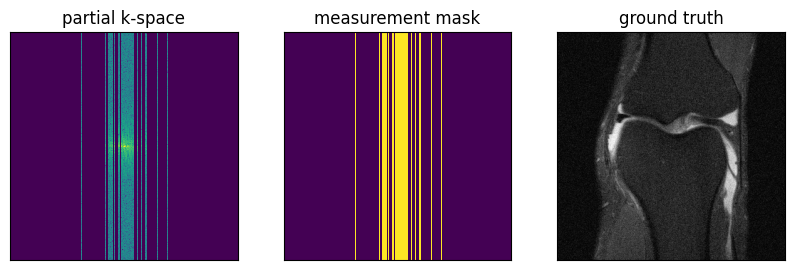

In [3]:
# Define parameters
batch_size = 1

# Create dataloaders 
train_loader, test_loader = Fast_MRI_dataloader.create_dataloaders(data_loc2, batch_size)

print(f"Number of training batches: {len(train_loader)}"
        f"\nNumber of test batches: {len(test_loader)}")

  0%|          | 0/750 [00:00<?, ?it/s]

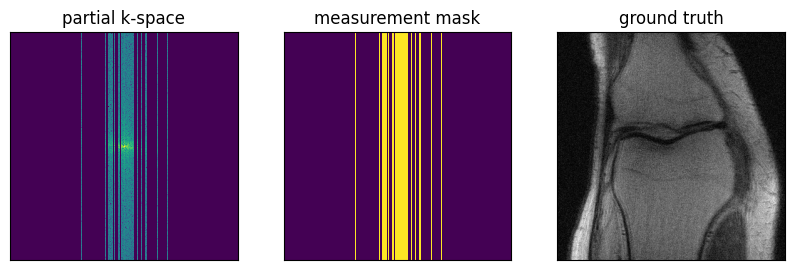

  0%|          | 0/750 [00:00<?, ?it/s]


In [45]:
# Go over the dataset
for i,(kspace, M, gt) in enumerate(tqdm(train_loader)):

    # plot the example
    kspace_plot_friendly = torch.log(torch.abs(kspace[0,:,:])+1e-20)

    plt.figure(figsize = (10,10))
    plt.subplot(1,3,1)
    plt.imshow(kspace_plot_friendly, vmin=-2.3, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('partial k-space')

    plt.subplot(1,3,2)
    plt.imshow(M[0,:,:], interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('measurement mask')

    plt.subplot(1,3,3)
    plt.imshow(gt[0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('ground truth')

    # Save the figure
    plt.savefig("figures/Fast_MRI_Example", dpi=300, bbox_inches='tight')
    plt.show()

    break

## Exercise 3 - MRI helper functions

### (a) [2pt] Create a Python function that, given an MRI image, calculates the K-space.
- Make sure to only use PyTorch functions and that the function can work on multiple images in parallel. 
- Visualize a ground truth image with its accompanying full k-space measurement.
- hint: make sure that the DC (i.e., 0 Hz component) is at the center of the image. Moreover, plotting the log of the absolute value of the k-space provides better contrast

  0%|          | 0/750 [00:00<?, ?it/s]

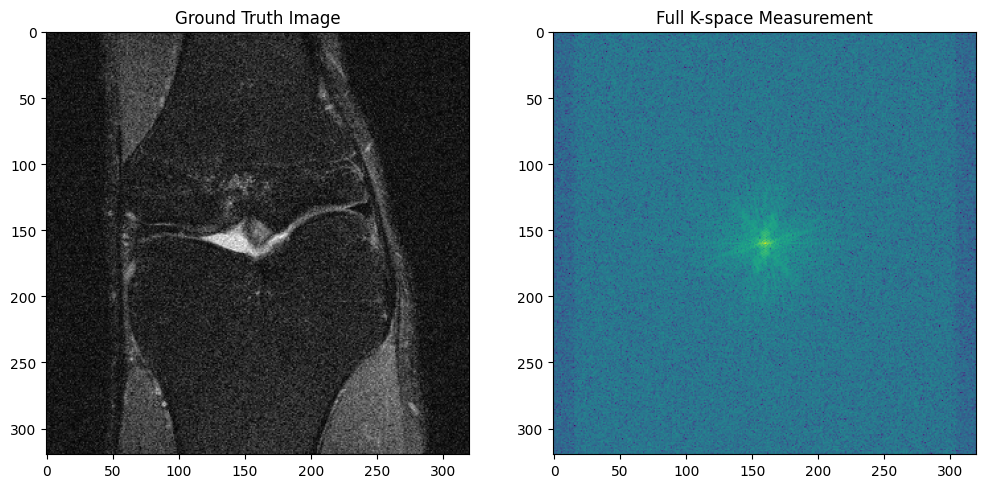

  0%|          | 0/750 [00:00<?, ?it/s]


In [4]:
def calculate_k_space(images):
    # Compute the Fourier Transform
    k_space = torch.fft.fftn(images)
    # Shift the zero-frequency component to the center
    k_space = torch.fft.fftshift(k_space, dim=(-2, -1))
    return k_space

# Go over the dataset
for i, (_, M, gt) in enumerate(tqdm(train_loader)):
    # Calculate K-space for the ground truth image
    k_space = calculate_k_space(gt)
    
    plt.figure(figsize=(15, 5))

    # Plot the whole k-space (log of absolute value for better contrast)
    plt.subplot(1, 3, 1)
    plt.imshow(torch.log(torch.abs(k_space[0,:,:])+1e-20), vmin=-2.3, interpolation='nearest')
    plt.title('Full K-space')

    # Plot the ground truth image
    plt.subplot(1, 3, 2)
    plt.imshow(gt[0,:,:], cmap='gray')
    plt.title('Ground Truth Image')

    plt.show()

    # Break the loop
    break

### (b) [1pt] Create a Python function that, given a full k-space and measurement matrix, calculates the partial k-space.

In [47]:
def calculate_partial_k_space(full_k_space, measurement_matrix):
    """
    Calculate the partial k-space given a full k-space and a measurement matrix.

    Parameters:
    full_k_space (torch.Tensor): The full k-space.
    measurement_matrix (torch.Tensor): The measurement matrix.

    Returns:
    torch.Tensor: The partial k-space.
    """
    return full_k_space * measurement_matrix

### (c) [2pt] Create a Python function that, given a partial k-space, calculates the accelerated measurement image. 
- Visualize a partial k-space with its accompanying accelerated MRI.

In [48]:
def calculate_accelerated_measurement(partial_k_space):
    """
    Calculate the accelerated measurement image given a partial k-space.

    Parameters:
    partial_k_space (torch.Tensor): The partial k-space.

    Returns:
    torch.Tensor: The accelerated measurement image.
    """
    return torch.fft.ifft2(partial_k_space)

### (d) [1pt] Recreate the pipeline image shown above for a different MRI image.
- hint: for the best result, use the same ’vmin’ and ’vmax’ for the full and partial k-space images

  0%|          | 0/750 [00:00<?, ?it/s]

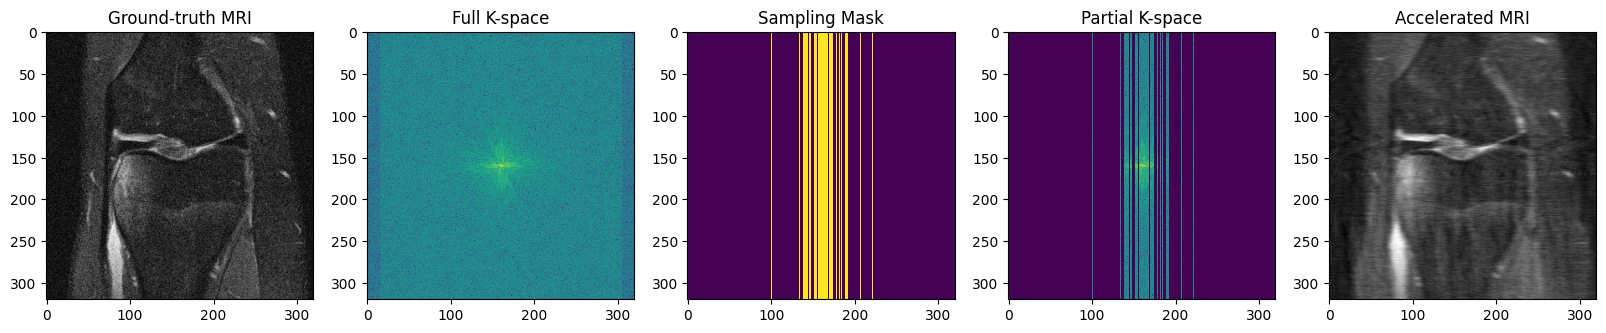

  0%|          | 0/750 [00:00<?, ?it/s]


In [49]:
# Go over the dataset
for i, (_, M, gt) in enumerate(tqdm(train_loader)):
    # Calculate K-space for the ground truth image
    k_space = calculate_k_space(gt)
    
    partial_k_space = calculate_partial_k_space(k_space, M)

    accelerated_measurement = calculate_accelerated_measurement(partial_k_space)

    plt.figure(figsize=(20, 5))

    # Ground truth image
    plt.subplot(1, 5, 1)
    plt.imshow(gt[0,:,:], cmap='gray')
    plt.title('Ground-truth MRI')

    # Plot the whole k-space (log of absolute value for better contrast)
    plt.subplot(1, 5, 2)
    plt.imshow(torch.log(torch.abs(k_space[0,:,:])+ 1e-20), vmin=-2.3, interpolation='nearest')
    plt.title('Full K-space')

    # Measurement matrix
    plt.subplot(1, 5, 3)
    plt.imshow(M[0,:,:], interpolation='nearest')
    plt.title('Sampling Mask')

    # Partial k-space
    plt.subplot(1, 5, 4)
    plt.imshow(torch.log(torch.abs(partial_k_space[0,:,:]) + 1e-20), vmin=-2.3, interpolation='nearest')
    plt.title('Partial K-space')

    # Accelerated measurement image
    plt.subplot(1, 5, 5)
    plt.imshow(torch.abs(accelerated_measurement[0,:,:]), cmap='gray')
    plt.title('Accelerated MRI')

    plt.show()

    # Break the loop
    break

### (e) [1pt] In the accelerated MRI image it looks as though the same image is overlayed several times, what is this effect called, and why does it only happen in the horizontal direction?

Answer: In the context of MRI, this can happen when the k-space is undersampled, as is the case with accelerated MRI techniques. The reason it only happens in the horizontal direction is likely due to the way the MRI data is acquired. MRI data is typically acquired line by line in the k-space, from top to bottom. This is called phase encoding. If the k-space is undersampled, it means that not all lines are acquired, which results in aliasing in the phase encoding direction.

## Exercise 4 - ISTA for MRI

### (a) [3 pt] Create a Python function that implements ISTA for accelerated MRI. 
- Make sure the function takes as inputs: step size μ, shrinkage parameter λ, number of iteration K, a batch of k-space measurements and the accompanying batch of measurement masks M. 
- It should output the final batch of reconstructions xK .

In [63]:
def shrinkage_thresholding(X, shrinkage):
    """
    Implement the shrinkage thresholding operator.

    Parameters:
    X (torch.Tensor): The input tensor.
    shrinkage (float): The shrinkage parameter.

    Returns:
    torch.Tensor: The output tensor.
    """
    return torch.sign(X) * torch.clamp(torch.abs(X) - shrinkage, min=0)

def ista_mri(mu, shrinkage, K, k_space_batch, M_batch):
    """
    Implement ISTA for accelerated MRI.

    Parameters:
    mu (float): The step size.
    shrinkage (float): The shrinkage parameter.
    K (int): The number of iterations.
    k_space_batch (torch.Tensor): The batch of k-space measurements. Shape: (batch_size, ...)
    M_batch (torch.Tensor): The batch of measurement masks. Shape: (batch_size, ...)

    Returns:
    torch.Tensor: The final batch of reconstructions. Shape: (batch_size, ...)
    """
    # Initialize the reconstruction with the inverse Fourier transform of the k-space measurements
    X = torch.fft.ifft2(k_space_batch)

    # Perform the data consistency and shrinkage steps for K iterations
    for _ in tqdm(range(K)):
        # Data consistency step
        X = torch.abs(torch.fft.ifft2(torch.fft.fft2(X) - mu * M_batch * torch.fft.fft2(X) + mu * M_batch * k_space_batch))

        # Shrinkage step
        X = shrinkage_thresholding(X, mu * shrinkage)

    return X

### (b) [2 pt] Use your ISTA algorithm on 5 images from the test set. 
- Show them in a figure consisting of 5 collumns (1 per image) and 3 rows. 
- Row 1 should contain the initial reconstruction from partial k-space, row 2 the reconstruction after ISTA, and row 3 the actual ground truth target. 
- You will have to play with the values for μ, λ, and K.
- Explain what you see.

100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


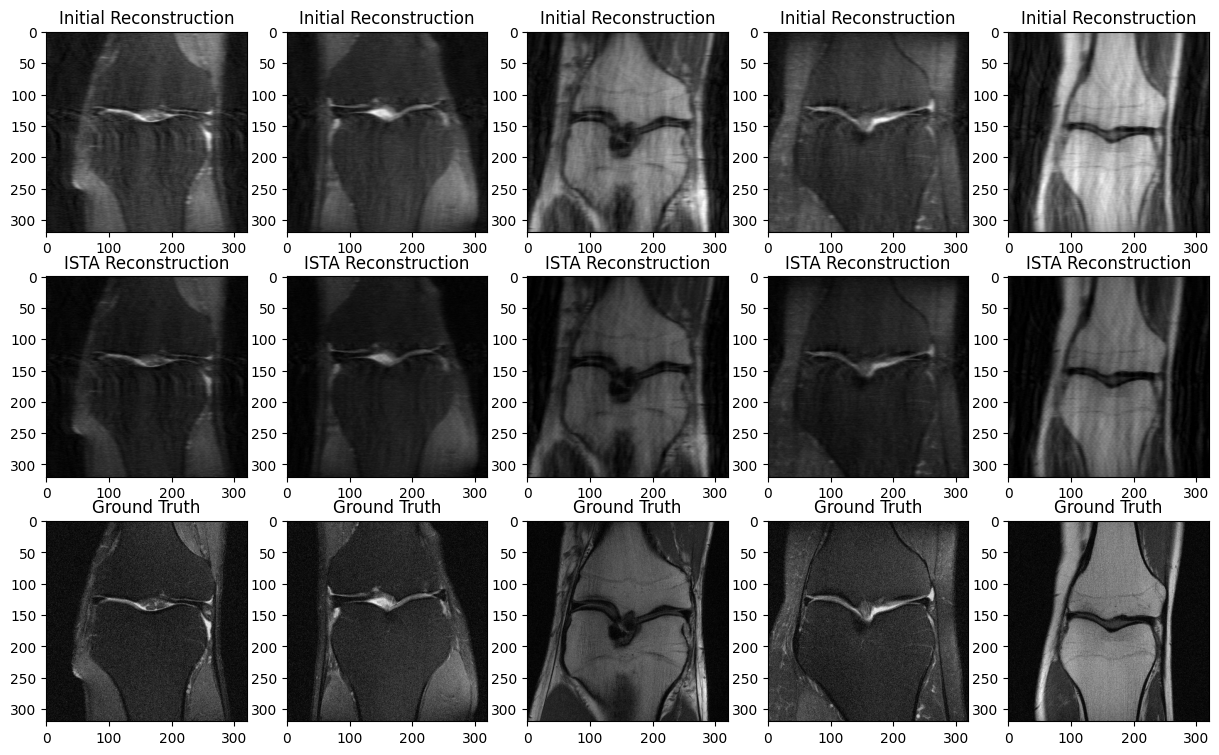

In [66]:
mu = 2.0
shrinkage = 0.01
K = 10

# Select 5 images from the test set
images = []
for i, (_, M, gt) in enumerate(test_loader):
    if i >= 5:
        break
    images.append((M, gt))

# Initialize the figure
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

#  Go over the dataset
for i, (M, gt) in enumerate(tqdm(images)):
    # Calculate K-space for the ground truth image
    k_space = calculate_k_space(gt)
    
    partial_k_space = calculate_partial_k_space(k_space, M)

    accelerated_measurement = calculate_accelerated_measurement(partial_k_space)

    ista_reconstruction = ista_mri(mu, shrinkage, K, partial_k_space, M)

    # Plot the initial reconstruction
    axs[0, i].imshow(torch.abs(accelerated_measurement[0,:,:]), cmap='gray')
    axs[0, i].set_title('Initial Reconstruction')

    # Plot the reconstruction after ISTA
    axs[1, i].imshow(torch.abs(ista_reconstruction[0,:,:]), cmap='gray')
    axs[1, i].set_title('ISTA Reconstruction')

    # Plot the actual ground truth target
    axs[2, i].imshow(gt[0,:,:], cmap='gray')
    axs[2, i].set_title('Ground Truth')

### (c) [1 pt] To get a numerical estimate for the performance of ISTA, run it on the entire test set and report the resulting mean squared error (mse).

---
## Week 3

## Exercise 5 - ConvNet

### (a) [1pt] What loss function would be most suitable to train this network, and what underlying assumption have you made by choosing this loss function?

Answer:
MSE loss function would make sense for a reconstruction due to the pixelwise error nature. The underlying assumption made is that the reconstruction errors follow a Gaussian distribution.

### (b) [3pt] Design a convolutional neural network of no more than 4 layers. 
- Train it for at least 10 epochs and plot both the training loss and testing loss in terms of epochs or batches seen. 
- Make suitable design choices.

In [6]:
class kneeNET():
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1,32,kernel_size=5,padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.c2 = nn.Conv2d(32,64,kernel_size=5,padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.c2 = nn.Conv2d(32,64,kernel_size=5,padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.c3 = nn.Conv2d(64,32,kernel_size=5,padding=2)
        self.bn3 = nn.BatchNorm2d(32)

        self.c4 = nn.Conv2d(32,1,kernel_size=1)

        self.gelu = nn.GELU()

    def forward(self, input):
        x = self.c1(input)
        x = self.bn1(x)
        x = self.gelu(x)

        x = self.c2(x)
        x = self.bn2(x)
        x = self.gelu(x)

        x = self.c3(x)
        x = self.bn3(x)
        x = self.gelu(x)

        x = self.c4(x)

        return x



### (c) [2pt] Repeat exercise 4c using your trained ConvNet.

### (d) [1pt] Repeat exercise 4d using your trained ConvNet

---
## Week 3

## Exercise 6 - Neural proximal gradient descent

### (a) [1pt] Explain what the difference is between LISTA and neural proximal gradient descent. 
- Why would the latter be a more suitable choice for accelerated MRI?

Answer: [response here]

### (b) [4pt] Implement neural proximal gradient descent for 5 unfolded iterations. 
- As proximal operator, make use of the ConvNet you designed in exercise 5. 
- Train it for at least 10 epochs and plot both the training loss and testing loss in terms of epochs or batches seen.
- hint: μ should remain between 0 and 1. Moreover, it helps to set a higher learning rate for the μs compared to the other trainable parameters

### (c) [2pt] Repeat exercise 4c using your trained ProxNet.

### (d) [1pt] Repeat exercise 4d using your trained ProxNet.

### (e) [2pt] A direct comparison between your ProxNet and ConvNet might not be fair, why? 
- Can you think of a way to make the comparison fairer? Implement this and compare mse again